This notebook contains a couple of examples, and will be extended over time. Please see the documentation for more detailed information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Setting up an `Ensemble`

In [2]:
from scdc.ensemble import Ensemble
from scdc.event import Event
from scdc.particle import Quasiparticle
from scdc.materials import ALUMINUM
from scdc import plot  # Contains matplotlib configuration code

Let's configure an `Ensemble` of 1000 copies of a quasiparticle in the forward direction with energy $5\Delta$.

In [3]:
qp = Quasiparticle(energy=5, cos_theta=1, material=ALUMINUM)
simulation = Ensemble(
    [Event([qp], ALUMINUM)], # Represents an `Event` with one QP in the initial state
    copies=1000
)

Now we can run the down-conversion process recursively until all final states are ballistic.

In [4]:
simulation.chain()

We can see all of the initial-state particles in the ensemble using the `initial_state` attribute. For example, all of these have energy $5\Delta$:

In [5]:
simulation.initial_state

The `ParticleCollection` is list-like and can be sliced:

In [6]:
simulation.initial_state[:5]

…but also supports accessing some attributes for all particles at once:

In [7]:
simulation.initial_state[:5].energy

array([5., 5., 5., 5., 5.])

We can access the final state of each event individually by indexing the `Ensemble`:

In [8]:
simulation[0]

<Event [QP]---QuasiparticlePhononEmission--->[QP,Ph]>

In [9]:
list(simulation[0].out)

[<QP E=1.303, k/kF-1=6.444e-06, cos(theta)=1.000>,
 <Ph E=3.697, k/kF-1=1.756e+05, cos(theta)=0.008>]

And we can access the final-state particles after down-conversion using the `leaf_particles` attribute:

In [10]:
len(simulation.leaf_particles)

18009

We can subset to look only at a certain particle type:

In [11]:
simulation.leaf_particles.quasiparticles

and we can e.g. make a plot of their angular distribution.

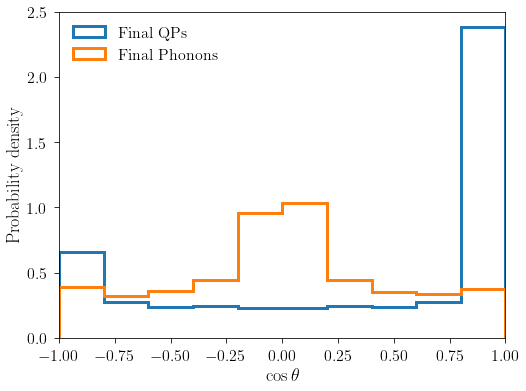

In [12]:
plt.hist(simulation.leaf_particles.quasiparticles.cos_theta,
         density=True, label='Final QPs', histtype='step', lw=3)
plt.hist(simulation.leaf_particles.phonons.cos_theta,
         density=True, label='Final Phonons', histtype='step', lw=3)
plt.legend(loc=2)
plt.xlim(-1, 1)
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Probability density');

# Sampling initial excitations

We can also sample initial excitations from dark matter scattering. This version uses a coarse grid for a fast demonstration.

In [13]:
from scdc.initial.distribution.integral import InitialSampler
from scdc.initial.halo import StandardHaloDistribution
from scdc.initial.response import HybridResponseFunction
from scdc.initial.matrix_element import FiducialMatrixElement

Configure the model-dependent ingredients:

In [14]:
KMS = 3.33564e-6  # km/s in natural units
material = ALUMINUM
vdf = StandardHaloDistribution(
    v_0=220*KMS/material.v,
    v_esc=550*KMS/material.v,
    v_wind=230*KMS/material.v
)
response = HybridResponseFunction(material, 1)

Fix the DM mass and assume a massless mediator. Note that `material.m` is the material mass unit in eV, so the below sets up a model with a DM mass of 3 keV.

In [15]:
me = FiducialMatrixElement(mediator_mass=0)
m_nt = 3e3 / material.m

Now we can initialize the sampler. Note that initialization is the expensive step, here made much faster by the use of too-small values for `n_cq`, `n_rq`, and `n_v1`. (See the module `mpi.initial` for suggested configuration.)

In [16]:
%%time
sampler_nt = InitialSampler(m_nt, me, material, response, vdf, n_cq=20, n_rq=20)

CPU times: user 1min 6s, sys: 346 ms, total: 1min 6s
Wall time: 1min 8s


Finally, we can draw samples from the ensemble:

In [17]:
%%time
simulation = sampler_nt.ensemble(1000)

CPU times: user 9.28 s, sys: 150 ms, total: 9.43 s
Wall time: 11.1 s


Now `simulation` is an `Ensemble` with 1000 initial quasiparticle pairs, and we can run `chain()` to down-convert these initial excitations. For now, though, to look at the initial quasiparticles we have generated, we can tell `simulation` to consider these quasiparticles to be the final states:

In [18]:
for e in simulation:
    for p in e.out:
        p.dest.final = True

…and now we can access them with `leaf_particles`:

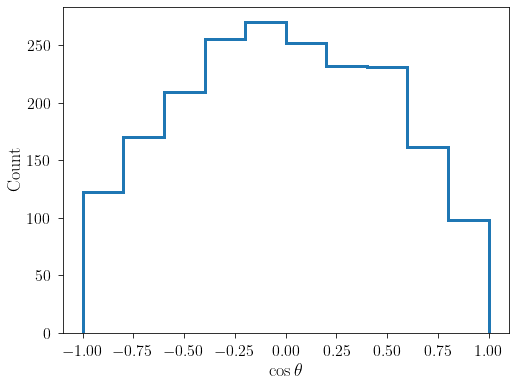

In [19]:
plt.hist(simulation.leaf_particles.quasiparticles.cos_theta, histtype='step', lw=3)
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Count');